## The physics informed neural networks: implementation 

## (1) Solving the 1D Darcy’s Flow Problem with PINN

Darcy’s law describes the flow of a fluid through a porous medium. In 1D, it is given by the steady-state equation:
$$
-\frac{d}{dx} \left( k(x) \frac{d p}{dx} \right) = f(x), \quad x \in [0,1]
$$
where:
- $p(x)$ is the pressure (unknown),
- $k(x)= (1 + \sin(\frac{3\pi}{2}x))/3$ is the permeability of the medium,
- $f(x)=\frac{3\pi^2}{4}(\cos(\frac{3\pi}{2}x)+\sin(3\pi x))$ is an external source term.

We impose Dirichlet boundary conditions:
$$
p(0) = 1, \quad p(1) = 0
$$


### (1.1) Step 1: Approximating the Solution with a Neural Network

In [2]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
device = 'cpu'
#
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Activation
        self.activation = nn.Tanh()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return x
#
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
from torchsummary import summary
summary(model_u, input_size=(1,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]              80
              Tanh-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
              Tanh-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
              Tanh-6                   [-1, 40]               0
            Linear-7                   [-1, 40]           1,640
              Tanh-8                   [-1, 40]               0
            Linear-9                    [-1, 1]              41
Total params: 5,041
Trainable params: 5,041
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
-----------------------------------------------

### (1.2) Step 2: Obtain the training data (and testing data)

Size of boundary points: torch.Size([2, 1])
Size of collocation points: torch.Size([10000, 1])
Size of testing points: torch.Size([1000, 1])


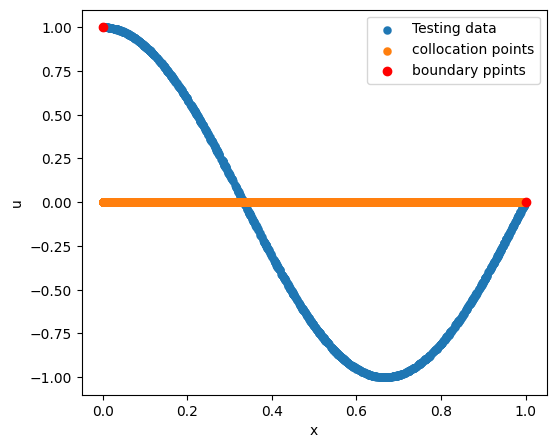

In [3]:
lb, ub = [0.], [1.]
nc = 10000
dataType = torch.float32
np.random.seed(1234)
################################# The boundary points (x=0) and (x=1)
x_lb = np.array(lb)
x_rb = np.array(ub)
#
x_bd = np.vstack([x_lb, x_rb])
x_bd = torch.tensor(x_bd, dtype=dataType)
u_bd = torch.tensor([[1.], [0.]], dtype=dataType)
print('Size of boundary points:', x_bd.shape)
################################# The collocation points (x)
x_in = np.random.uniform(lb, ub, nc).reshape(-1,1)
x_in = torch.tensor(x_in, dtype=dataType)
print('Size of collocation points:', x_in.shape)
################################# The testing dataset (x,u)
x_test = np.random.uniform(lb, ub, 1000).reshape(-1,1)
u_test = np.cos(3*np.pi*x_test/2)
x_test, u_test = torch.tensor(x_test, dtype=dataType),  torch.tensor(u_test, dtype=dataType)
print('Size of testing points:', x_test.shape)
#
plt.figure(figsize=(6,5))
plt.scatter(x_test, u_test, label='Testing data', linewidth=0.1)
plt.scatter(x_in, torch.zeros_like(x_in), label='collocation points', linewidth=0.1)
plt.scatter(x_bd, u_bd, color='r', label='boundary ppints')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

### (1.3) Defining the loss function
The boundary condition:
$$
L_{bd/ic}(\theta) = \frac{1}{N_{bd}}\sum^{N_{bd}}_{i=1}|u_\theta(x_i)|^2 \tag{1}
$$
The PDE loss:
$$
L_{PDE}(\theta) = \frac{1}{N_c}\sum^{N_c}_{i=1}|\frac{\partial }{\partial x}\left(k(x_i)\frac{\partial u}{\partial x}(x_i)\right) +f(x_i)|^2 \tag{2}
$$

In [6]:
from torch.autograd import grad, Variable
#
torch.manual_seed(1234)

class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model
        self.getLoss = torch.nn.MSELoss()
    
    def loss_bd(self, x_bd, u_bd):
        '''loss term related to boundary conditions'''
        x_bd = x_bd.to(self.device)
        u = self.u_model(x_bd)
        loss = self.getLoss(u, u_bd.to(self.device))
        
        return loss 
        
    def loss_pde(self, x_in):
        '''loss term related to the PDE'''
        loss = 0. 
        ################# The PDE loss
        x = Variable(x_in, requires_grad=True).to(self.device)
        u = self.u_model(x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # s = k*du
        s = (1 + torch.sin(torch.pi*3*x/2))/3 * du_dx
        ds_dx = grad(inputs=x, outputs=s, grad_outputs=torch.ones_like(s), create_graph=True)[0]
        # f(x)
        f = 3*torch.pi**2/4 * (torch.cos(3*torch.pi*x/2) + torch.sin(3*torch.pi * x))
        # The residuals
        residual = - ds_dx - f
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual))
        
        return loss

    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))
        
########################## Create DataLoader for Mini-Batch Training
from torch.utils.data import Dataset, DataLoader
#
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]
        
dataloader = DataLoader(MyDataset(x_in), batch_size=100, shuffle=True)

############ Training setups
from tqdm import trange
#
epochs = 500
lr = 1e-3
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/5), gamma=0.5)
#
w_pde = 2.
w_bd = 10.
############ The training process
error_list = []
for epoch in trange(epochs):
    for x_batch in dataloader:
        lossClass = LossClass(model_u)
        ############# Calculate losses
        loss_bd = lossClass.loss_bd(x_bd, u_bd)
        loss_in = lossClass.loss_pde(x_batch)
        loss_train = w_pde*loss_in + w_bd*loss_bd
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    #
    with torch.no_grad():
        error = lossClass.get_error(x_test, u_test)
        error_list.append(error.item())
    #
    scheduler.step()  # Adjust learning rate
    if (epoch+1)%25==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')

  5%|██▏                                       | 26/500 [00:04<01:15,  6.28it/s]

Epoch:24, The loss is:0.00033940328285098076, lr: 0.001


 10%|████▎                                     | 51/500 [00:08<01:14,  6.04it/s]

Epoch:49, The loss is:0.000585892063099891, lr: 0.001


 15%|██████▍                                   | 76/500 [00:12<01:07,  6.31it/s]

Epoch:74, The loss is:0.00020551263878587633, lr: 0.001


 20%|████████▎                                | 101/500 [00:16<01:02,  6.38it/s]

Epoch:99, The loss is:4.44494144176133e-05, lr: 0.0005


 25%|██████████▎                              | 126/500 [00:20<01:00,  6.23it/s]

Epoch:124, The loss is:3.1269799364963546e-05, lr: 0.0005


 30%|████████████▍                            | 151/500 [00:24<00:55,  6.28it/s]

Epoch:149, The loss is:0.004210811574012041, lr: 0.0005


 35%|██████████████▍                          | 176/500 [00:28<00:52,  6.19it/s]

Epoch:174, The loss is:3.682417082018219e-05, lr: 0.0005


 40%|████████████████▍                        | 201/500 [00:32<00:49,  6.07it/s]

Epoch:199, The loss is:7.921171345515177e-05, lr: 0.00025


 45%|██████████████████▌                      | 226/500 [00:36<00:43,  6.36it/s]

Epoch:224, The loss is:1.799759775167331e-05, lr: 0.00025


 50%|████████████████████▌                    | 251/500 [00:40<00:39,  6.26it/s]

Epoch:249, The loss is:5.044354111305438e-05, lr: 0.00025


 55%|██████████████████████▋                  | 276/500 [00:45<00:36,  6.10it/s]

Epoch:274, The loss is:1.1410390470700804e-05, lr: 0.00025


 60%|████████████████████████▋                | 301/500 [00:49<00:30,  6.60it/s]

Epoch:299, The loss is:0.0007955898181535304, lr: 0.000125


 65%|██████████████████████████▋              | 326/500 [00:53<00:28,  6.05it/s]

Epoch:324, The loss is:2.115487768605817e-05, lr: 0.000125


 70%|████████████████████████████▊            | 351/500 [00:57<00:23,  6.43it/s]

Epoch:349, The loss is:4.8618181608617306e-05, lr: 0.000125


 75%|██████████████████████████████▊          | 376/500 [01:01<00:19,  6.45it/s]

Epoch:374, The loss is:1.872191387519706e-05, lr: 0.000125


 80%|████████████████████████████████▉        | 401/500 [01:05<00:15,  6.29it/s]

Epoch:399, The loss is:6.125434447312728e-05, lr: 6.25e-05


 85%|██████████████████████████████████▉      | 426/500 [01:09<00:11,  6.42it/s]

Epoch:424, The loss is:2.9789864129270427e-05, lr: 6.25e-05


 90%|████████████████████████████████████▉    | 451/500 [01:13<00:07,  6.31it/s]

Epoch:449, The loss is:1.5151149455050472e-05, lr: 6.25e-05


 95%|███████████████████████████████████████  | 476/500 [01:17<00:03,  6.45it/s]

Epoch:474, The loss is:1.518513363407692e-05, lr: 6.25e-05


100%|█████████████████████████████████████████| 500/500 [01:20<00:00,  6.18it/s]

Epoch:499, The loss is:1.1641399396467023e-05, lr: 3.125e-05


### (1.4) make prediction with trained model

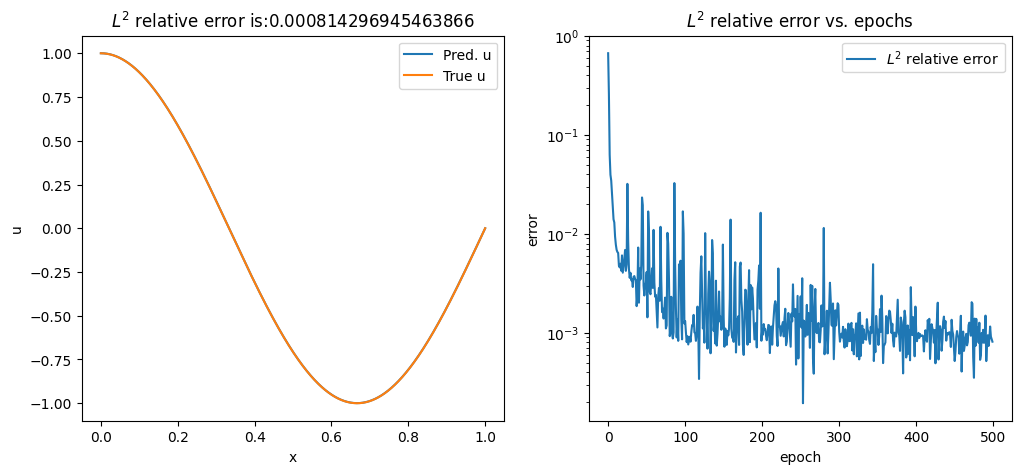

In [7]:
x_query = np.linspace(lb, ub, 1000)
x_query = torch.tensor(x_query, dtype=dataType)
#
u_true = torch.cos(torch.pi*3*x_query/2)
u_query = model_u(x_query.to(device)).detach().cpu()
error = torch.sqrt(torch.sum((u_true-u_query)**2)/torch.sum(u_true**2))
#
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].plot(x_query, u_query, label='Pred. u')
axes[0].plot(x_query, u_true, label='True u')
axes[0].set_title(f'$L^2$ relative error is:{error}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u')
axes[0].legend()
#
axes[1].semilogy(error_list, label='$L^2$ relative error')
axes[1].set_title('$L^2$ relative error vs. epochs')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('error')
axes[1].legend()
#
plt.show()

## (2) Solving the 1D Heat equation with PINN
\begin{equation}
\begin{split}
u_t - \mu u_{xx} &= 0,\quad x\in\Omega_T=[0,L]\times[0,1] \\
u(0, t) = u(L,t) &=0, \quad t\geq 0 \\
u(x, 0) &= 12\sin(\frac{9\pi}{L} x) - 7\sin(\frac{4\pi}{L} x),\quad x\in[0,L]
\end{split}
\end{equation}
where diffusivity constant $\mu=0.05$ and domain length $L=2$. The PDE has [explicit solution](https://tutorial.math.lamar.edu/classes/de/solvingheatequation.aspx):
$$
u(x,t) = 12\sin(\frac{9\pi}{L} x)e^{-\mu(\frac{9\pi}{L})^2t} - 7\sin(\frac{4\pi}{L} x)e^{-\mu(\frac{4\pi}{L})^2t}
$$

<center>
    <img src="../Figures/PINN_heat.svg" width = "600" height='600' alt=""/>
    <br>
    <div style="color:gray">
      A uniform bar of length  𝐿
  	</div>
</center>

### (2.1) Step 1: Approximating the Solution with a Neural Network

In [8]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import torch.nn as nn
device = 'cpu'
#
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Activation
        self.activation = nn.Tanh()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return x
#
model_u = MLP([2, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
from torchsummary import summary
summary(model_u, input_size=(2,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]             120
              Tanh-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
              Tanh-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
              Tanh-6                   [-1, 40]               0
            Linear-7                   [-1, 40]           1,640
              Tanh-8                   [-1, 40]               0
            Linear-9                    [-1, 1]              41
Total params: 5,081
Trainable params: 5,081
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
-----------------------------------------------

### (2.2) Step 2: Obtain the training data (and testing data)

Size of collocation points: torch.Size([50000, 2])
Size of initial points: torch.Size([500, 2])
Size of boundary points: torch.Size([500, 2])
Size of testing points: torch.Size([5000, 2])


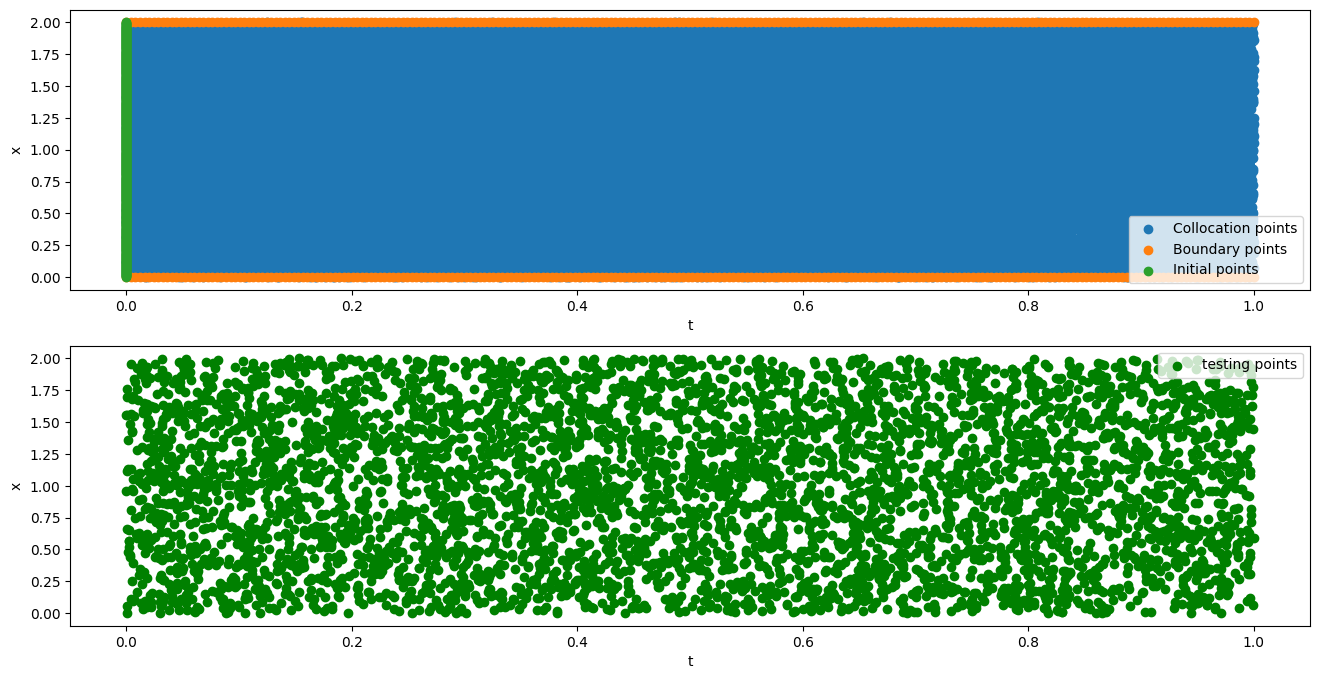

In [10]:
mu, L = 0.05, 2
lb, ub = [0.], [L]
t0, tT = [0.], [1.]
#
nc = 50000
n_ic = 500
n_bd_each_side = 250
dataType = torch.float32
np.random.seed(1234)
###### The truth solution: for generating the testing dataset, the initial condition, and the boundary condition
def u_true(xt):
    '''The ground truth solution'''
    x, t = xt[...,0:1], xt[...,1:2]
    s1, s2 = 9.*np.pi/L, 4.*np.pi/L
    #
    u = 12.*torch.sin(s1*x)*torch.exp(-mu*s1**2*t) - 7.*torch.sin(s2*x)*torch.exp(-mu*s2**2*t)
    
    return u
    
################################# The collocation points (x,t)
t_in = np.random.uniform(t0, tT, nc)
x_in = np.random.uniform(lb, ub, nc)
xt_in = np.vstack((x_in.flatten(), t_in.flatten())).T
xt_in = torch.tensor(xt_in, dtype=dataType)
print('Size of collocation points:', xt_in.shape)
################################# The initial points (x,t=0)
x_ic = np.linspace(lb, ub, n_ic)
t_ic = np.array(t0).repeat(n_ic, axis=0)
xt_ic = np.vstack((x_ic.flatten(), t_ic.flatten())).T
# initial condition
xt_ic = torch.tensor(xt_ic, dtype=dataType)
u_ic = u_true(xt_ic)
print('Size of initial points:', xt_ic.shape)
################################# The boundary points (x=-1,t) and (x=1,t)
t_bd = np.linspace(t0, tT, n_bd_each_side)
# The lower boundary
x_lb = np.array(lb).repeat(n_bd_each_side, axis=0)
xt_lb = np.vstack((x_lb.flatten(), t_bd.flatten())).T
xt_lb = torch.tensor(xt_lb, dtype=dataType)
# The upper boundary
x_ub = np.array(ub).repeat(n_bd_each_side, axis=0)
xt_ub = np.vstack((x_ub.flatten(), t_bd.flatten())).T
xt_ub = torch.tensor(xt_ub, dtype=dataType)
# boundary condition
xt_bd = torch.cat([xt_lb, xt_ub], dim=0)
u_bd = torch.zeros_like(xt_bd[...,0:1])
print('Size of boundary points:', xt_bd.shape)
################################# The testing dataset
t_test = np.random.uniform(t0, tT, 5000)
x_test = np.random.uniform(lb, ub, 5000)
xt_test = np.vstack((x_test.flatten(), t_test.flatten())).T
# testing dataset
xt_test = torch.tensor(xt_test, dtype=dataType)
u_test = u_true(xt_test)
print('Size of testing points:', xt_test.shape)
##################################
fig, axes = plt.subplots(2, 1, figsize=(16, 8))
axes[0].scatter(xt_in[...,-1], xt_in[...,0], label='Collocation points')
axes[0].scatter(xt_bd[:,-1], xt_bd[:,0], label='Boundary points')
axes[0].scatter(xt_ic[:,-1], xt_ic[:,0], label='Initial points')
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
axes[0].legend()
#
axes[1].scatter(xt_test[:,-1], xt_test[:,0], color='g', label='testing points')
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
axes[1].legend()
plt.show()

#### (1.3) Defining the loss function
The boundary condition and initial condition loss:
$$
L_{bd/ic}(\theta) = \frac{1}{N_{bd}}\sum^{N_{bd}}_{i=1}|u_\theta(x_i,t_i) - g_R(x_i,t_i)|^2 + \frac{1}{N_{ic}}\sum^{N_{ic}}_{i=1}|u_\theta(x_i,0) - g_D(x_i)|^2 \tag{4}
$$

The PDE loss:
$$
L_{PDE}(\theta) = \frac{1}{N_c}\sum^{N_c}_{i=1}|\frac{\partial u_{\theta}}{\partial t}(x_i,t_i) -\mu \frac{\partial^2 u_\theta}{\partial x^2}(x_i,t_i)|^2 \tag{5}
$$

In [11]:
from torch.autograd import grad, Variable
#
torch.manual_seed(1234)

class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
        self.getLoss = torch.nn.MSELoss()
        #
        self.mu = mu
    
    def loss_bd_ic(self, x_bd, u_bd, x_ic, u_ic):
        '''loss term related to boundary/initial conditions'''
        ############## Loss term related to the boundary condition
        xt = xt_bd.to(self.device)
        u = self.u_model(xt)
        loss = self.getLoss(u, u_bd.to(self.device))
        ############## Loss term related to the initial condition
        xt = xt_ic.to(self.device)
        u = self.u_model(xt)
        loss += self.getLoss(u, u_ic.to(self.device))
        
        return loss 
        
    def loss_pde(self, xt_in):
        '''loss term related to the PDE'''
        ################# The PDE loss
        x = Variable(xt_in[...,0].reshape(-1, 1), requires_grad=True).to(self.device)
        t = Variable(xt_in[...,1].reshape(-1, 1), requires_grad=True).to(self.device)
        xt = torch.cat([x,t], dim=-1)
        #
        u = self.u_model(xt)
        du_dt = grad(inputs=t, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        #
        du_dxx = grad(inputs=x, outputs=du_dx, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
        # The residuals
        residual = du_dt - self.mu * du_dxx
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual))
        
        return loss
        
    def get_error(self, xt_test, u_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        xt_test = xt_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(xt_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))

########################## Create DataLoader for Mini-Batch Training
from torch.utils.data import Dataset, DataLoader
#
class MyDataset(Dataset):

    def __init__(self, xt):
        self.xt = xt

    def __getitem__(self, index):
        return self.xt[index]

    def __len__(self):
        return self.xt.shape[0]
        
dataloader = DataLoader(MyDataset(xt_in), batch_size=500, shuffle=True)
print(len(dataloader))
############ Training setups
from tqdm import trange
#
epochs = 200
lr = 1e-3
model_u = MLP([2, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
#
w_pde = 2.
w_bd_ic = 10.
############ The training process
error_list = []
for epoch in trange(epochs):
    for xt_batch in dataloader:
        lossClass = LossClass(model_u)
        ############# Calculate losses
        loss_bd_ic = lossClass.loss_bd_ic(xt_bd, u_bd, xt_ic, u_ic)
        loss_in = lossClass.loss_pde(xt_batch)
        loss_train = w_pde*loss_in + w_bd_ic*loss_bd_ic
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    #
    with torch.no_grad():
        error = lossClass.get_error(xt_test, u_test)
        error_list.append(error.item())
    scheduler.step()  # Adjust learning rate
    #
    if (epoch+1)%25==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_list.pop())

100


 12%|█████▎                                    | 25/200 [00:12<01:22,  2.13it/s]

Epoch:24, The loss is:44.40435791015625, lr: 0.001
0.19543659687042236


 25%|██████████▌                               | 50/200 [00:24<01:18,  1.90it/s]

Epoch:49, The loss is:3.309905529022217, lr: 0.0005
0.03069278597831726


 38%|███████████████▊                          | 75/200 [00:36<00:57,  2.19it/s]

Epoch:74, The loss is:1.0903854370117188, lr: 0.0005
0.013330050744116306


 50%|████████████████████▌                    | 100/200 [00:48<00:50,  1.99it/s]

Epoch:99, The loss is:0.4605505168437958, lr: 0.00025
0.01568722352385521


 62%|█████████████████████████▋               | 125/200 [01:00<00:33,  2.25it/s]

Epoch:124, The loss is:0.20886573195457458, lr: 0.00025
0.011971036903560162


 75%|██████████████████████████████▊          | 150/200 [01:11<00:22,  2.24it/s]

Epoch:149, The loss is:0.23406779766082764, lr: 0.000125
0.007601609453558922


 88%|███████████████████████████████████▉     | 175/200 [01:23<00:11,  2.21it/s]

Epoch:174, The loss is:0.11310602724552155, lr: 0.000125
0.0047053503803908825


100%|█████████████████████████████████████████| 200/200 [01:34<00:00,  2.11it/s]

Epoch:199, The loss is:0.09027419984340668, lr: 6.25e-05
0.004651654977351427


### (1.4) make prediction with trained model

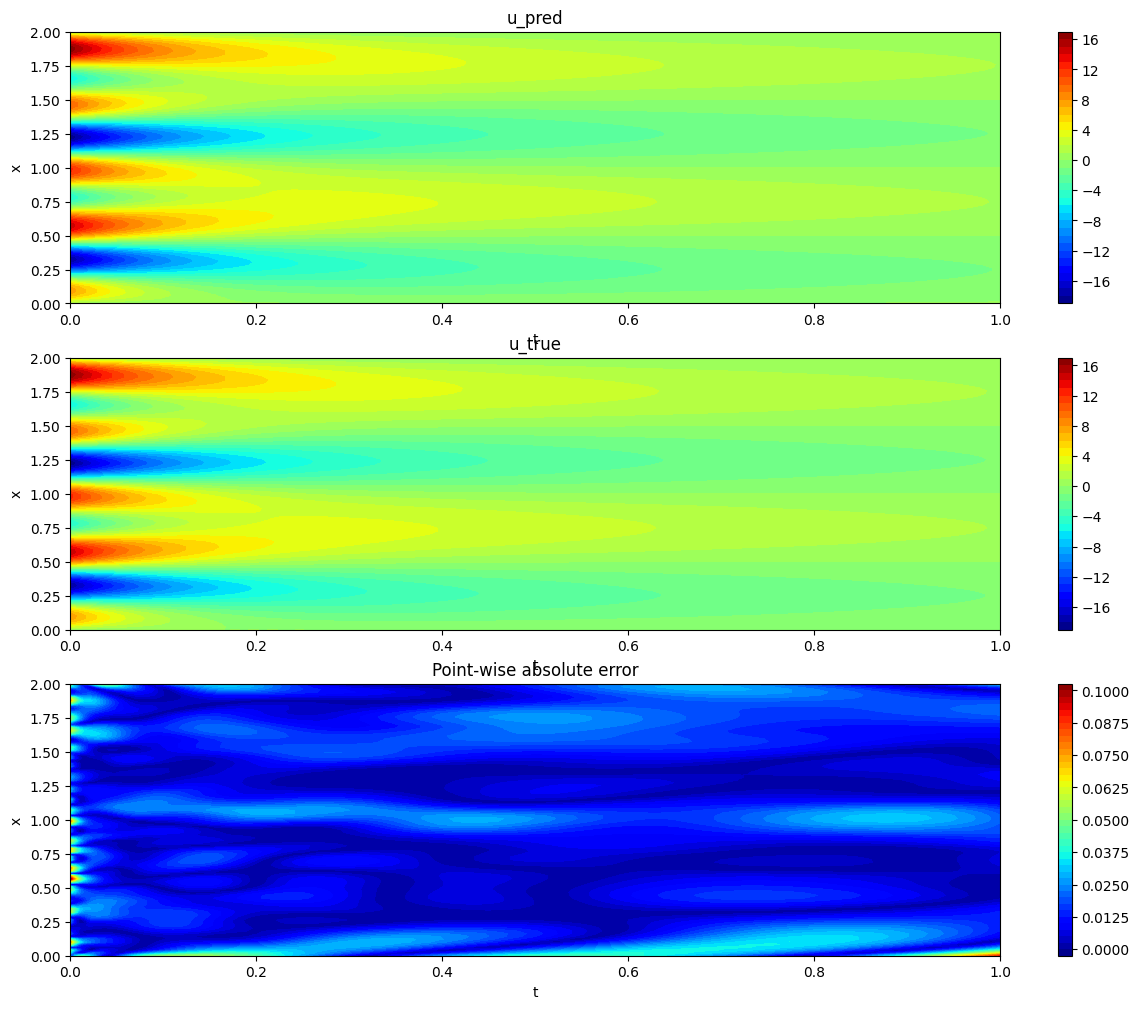

In [12]:
from scipy.interpolate import griddata

####### Make prediction with the trained model
# The grids (x,t)
t_grid = np.linspace(t0, tT, 100)
x_grid = np.linspace(lb, ub, 100)
xt_mesh = np.meshgrid(x_grid, t_grid)
xt_query= np.vstack((xt_mesh[0].flatten(), xt_mesh[1].flatten())).T
xt_query = torch.tensor(xt_query, dtype=dataType)
# The prediction
u_query = model_u(xt_query.to(device)).detach()
u_ref = u_true(xt_query)

####### Visualize the solution
mesh = np.meshgrid(np.linspace(lb, ub, 100), np.linspace(t0, tT, 200))
x_plot, t_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 4*3))
#
z_plot = griddata((xt_query[:,-1], xt_query[:,0]), np.ravel(u_query), (t_plot, x_plot), method='cubic')
cntr = axs.flat[:][0].contourf(t_plot, x_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][0])
axs.flat[:][0].set_title('u_pred')
axs.flat[:][0].set_xlabel('t')
axs.flat[:][0].set_ylabel('x')
#
z_plot = griddata((xt_query[:,-1], xt_query[:,0]), np.ravel(u_ref), (t_plot, x_plot), method='cubic')
cntr = axs.flat[:][1].contourf(t_plot, x_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][1])
axs.flat[:][1].set_title('u_true')
axs.flat[:][1].set_xlabel('t')
axs.flat[:][1].set_ylabel('x')
#
z_plot = griddata((xt_query[:,-1], xt_query[:,0]), np.abs(np.ravel(u_ref)-np.ravel(u_query)), (t_plot, x_plot), method='cubic')
cntr = axs.flat[:][2].contourf(t_plot, x_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absolute error')
axs.flat[:][2].set_xlabel('t')
axs.flat[:][2].set_ylabel('x')
#
plt.show()

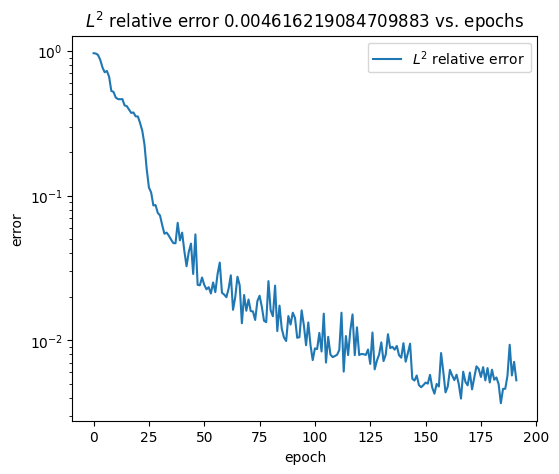

In [13]:
error = torch.sqrt(torch.sum((u_ref-u_query)**2)/torch.sum(u_ref**2))
#
plt.figure(figsize=(6,5))
plt.semilogy(error_list, label='$L^2$ relative error')
plt.title(f'$L^2$ relative error {error} vs. epochs')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
#
plt.show()

## (3) Exercise
### Task1: Solving the 2d Poisson Equation using PINN

The Poisson equation models steady-state problems in physics, such as electrostatics and heat conduction:
$$
-\nabla^2 u = - \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right) = f(x, y), \quad (x,y) \in \Omega=[-1,1]^2
$$
where $f(x,y)=2\pi^2\sin(\pi x)\sin(\pi y)$ and Dirichlet boundary condition is considered:
$$
u(x,y) = 0, \quad (x,y) \in \partial \Omega
$$


### Task2: Solving the 5d Poisson Equation using PINN
Now, let's consider a 5D Poisson equation with the following form:
$$
\begin{split}
-\Delta u &= f,\quad x\in\Omega=[-1,1]^{5} \\
u &= 0,\quad x\in\partial\Omega
\end{split}
$$
where $f(x)=5\lambda^2\pi^2\prod^{5}_{i=1}\sin(\lambda\pi x_i)$ and $\lambda=1$.